In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tf_keras.layers import *
import tf_keras as keras
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy
from skimage.transform import resize

%load_ext tensorboard
import datetime

2025-04-03 21:12:37.549177: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 21:12:37.558452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743739957.570731   35324 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743739957.573988   35324 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743739957.584211   35324 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Enable CUDA unified memory
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 4
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

I0000 00:00:1743739959.394410   35324 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31275 MB memory:  -> device: 0, name: NVIDIA RTX 3000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# Image loading

In [3]:
x_size = 48
y_size = 48

In [4]:
def img_to_vecs(img):
    output = np.zeros((x_size * y_size, 1, 2))
    rescaled_img = 2.0 * img.flatten() - 1.0
    output[:, 0, 0] = np.sin(rescaled_img * np.pi / 2.0)
    output[:, 0, 1] = np.cos(rescaled_img * np.pi / 2.0)
    return output

def vecs_to_img(vecs):
    v = vecs.reshape((x_size, y_size, 1, 2))
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    img = np.arcsin(v[:, :, 0, 0:1]) / np.pi * 2.0
    img = (1.0 + img) / 2.0
    img = 255.0 * np.clip(img, 0.0, 1.0)
    return img

In [5]:
ds = tfds.load('smallnorb', split='train', shuffle_files=True)

I0000 00:00:1743739959.569697   35324 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31275 MB memory:  -> device: 0, name: NVIDIA RTX 3000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
m = len(ds)
px_count = x_size * y_size
X_stereo = np.zeros((m, 2, px_count, 1, 2))
i = 0
for sample in ds:
    X_stereo[i][0] = img_to_vecs(resize((tf.cast(sample['image'], tf.float32).numpy() / 255.0), (x_size, y_size)))
    X_stereo[i][1] = img_to_vecs(resize((tf.cast(sample['image2'], tf.float32).numpy() / 255.0), (x_size, y_size)))
    i += 1

2025-04-03 21:12:39.656685: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-03 21:13:07.163186: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(24300, 2, 2304, 1, 2)


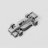

In [7]:
print(X_stereo.shape)
img = vecs_to_img(X_stereo[10000][0])
tf.keras.utils.array_to_img(img, scale=False)

# Layer architecture

In [8]:
def stable_norm(t, axis, keepdims=False):
    return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(t), axis=axis, keepdims=keepdims), keras.backend.epsilon()))

def l1_norm(t, axis, keepdims=False):
    return tf.reduce_sum(tf.abs(t), axis=axis, keepdims=keepdims)

### Locality and context layers

In [9]:
class ContextAggregationLayer(keras.layers.Layer):
    def __init__(self, context_fan_in, type_position_dim, instance_position_dim, num_samples, initial_sharpness, train_context, dtype=None):
        super(ContextAggregationLayer, self).__init__(dtype=dtype)

        self.context_fan_in = context_fan_in
        self.type_position_dim = type_position_dim
        self.instance_position_dim = instance_position_dim
        self.position_dim = type_position_dim + instance_position_dim
        self.num_samples = num_samples
        self.initial_sharpness = initial_sharpness
        self.train_context = train_context
    
    def build(self, input_shape):
        self.downstream_dim = input_shape[-1]
        self.downstream_num_instances = input_shape[-2]
        self.downstream_num_types = input_shape[-3]
        self.downstream_num = self.downstream_num_instances * self.downstream_num_types

        # Encodes the positions of downstream column types
        # Positions are within a unit ball.
        self.position_constraint = keras.constraints.MaxNorm(max_value=1, axis=1)
        self.downstream_type_positions = self.add_weight(
            shape=(self.downstream_num_types, self.type_position_dim),
            initializer=self.initialize_positions,
            name='type_positions',
            trainable=True,
            #use_resource=True,
            constraint=self.position_constraint,
        )
        self.downstream_instance_positions = self.add_weight(
            shape=(self.downstream_num_instances, self.instance_position_dim),
            initializer=self.initialize_positions,
            name='instance_positions',
            trainable=True,
            #use_resource=True,
            constraint=self.position_constraint,
        )
        
        # These rotations form the "neighborhood" of a given position.    
        # Shape: position_dim -> position_dim * context_fan_in
        self.context_queries = Dense(
            self.position_dim * self.context_fan_in,
            use_bias=False,
            kernel_initializer=self.initialize_rotations,
            name='context_queries',
            trainable=self.train_context,
            kernel_constraint=self.constrain_to_rotations,
        )
        
        self.context_sharpness = self.add_weight(
            shape=(self.context_fan_in,),
            initializer=keras.initializers.Constant(value=self.initial_sharpness),
            name='context_sharpness',
            trainable=True,
            #use_resource=True,
        )

        super(ContextAggregationLayer, self).build(input_shape)
    
    def initialize_positions(self, shape, dtype):
        rn = keras.initializers.TruncatedNormal()(shape, dtype=dtype)
        # Initializing to smaller values initially helps positions converge faster.
        return 0.1 * keras.constraints.UnitNorm(axis=1)(rn)
    
    def constrain_to_rotations(self, a):
        rs = tf.split(a, self.context_fan_in, axis=1)
        rs = tf.stack(rs)
        s, u, v = tf.linalg.svd(rs)
        vh = tf.linalg.adjoint(v)
        constrained_rs = tf.matmul(u, vh)
        
        return tf.concat(tf.unstack(constrained_rs), axis=1)
    
    def initialize_rotations(self, shape, dtype):
        identity = keras.initializers.Identity()((self.position_dim, self.position_dim), dtype=dtype)
        rotations = []
        # The first rotation is always the identity (i.e. the seed value itself)
        rotations.append(identity)
        for i in range(1, self.context_fan_in):
            rotation = keras.initializers.Orthogonal(gain=0.1)((self.position_dim, self.position_dim), dtype=dtype)
            rotations.append(identity + rotation)
        rotations = tf.concat(rotations, axis=1)
        return self.constrain_to_rotations(rotations)
    
    def sample_seed_indexes(self):
        # This tensorflow sampling method is inspired by https://stackoverflow.com/a/54755281
        # It approximates Numpy's np.random.choice with replace=False
        # Sampling different seed indexes for each batch helps the positions and contexts
        # to converge better to true neighborhoods. I was previously using a fixed sampling
        # throughout the whole training, and it led to the seed positions to get stuck
        # in specific values that didn't resemble their neighbors.

        uniform_distribution = tf.random.uniform([self.downstream_num_types * self.downstream_num_instances], minval=0.0, maxval=1.0)
        _, top_indexes = tf.nn.top_k(uniform_distribution, self.num_samples)

        return top_indexes
    
    def combine_positions(self):
        # Broadcast type positions over instances
        # Shape: (num_types * num_instances, type_position_dim)
        type_positions = tf.repeat(self.downstream_type_positions, self.downstream_num_instances, axis=0)
        
        # Shape: (num_types * num_instances, instance_position_dim)
        instance_positions = tf.repeat(self.downstream_instance_positions, self.downstream_num_types, axis=0)
        
        # Shape: (..., num_types * num_instances, position_dim)
        downstream_positions = tf.concat([type_positions, instance_positions], axis=-1)
        downstream_positions = self.position_constraint(downstream_positions)
        downstream_positions = tf.cast(downstream_positions, self.compute_dtype)
        
        return downstream_positions
        
    @tf.function(jit_compile=True)
    def reconstruct(self, full_context):
        downstream_positions = self.combine_positions()
        
        # Position shape: (..., num_columns, position_dim)
        # Value shape: (..., num_columns, context_fan_in * downstream_dim)
        position, values = tf.split(
            full_context,
            [
                self.position_dim,
                self.context_fan_in * self.downstream_dim,
            ],
            axis=-1,
        )
        
        # Restore scale
        values *= np.sqrt(self.context_fan_in)

        # Shape: (context_fan_in, ..., num_columns, downstream_dim)
        values = tf.stack(tf.split(values, self.context_fan_in, axis=-1), axis=0)

        # Shape: (..., num_columns, context_fan_in * position_dim)
        queries = self.context_queries(position)
        
        # Shape: (context_fan_in, ..., num_columns, position_dim)
        queries = tf.stack(tf.split(queries, self.context_fan_in, axis=-1), axis=0)
        
        # Shape: (context_fan_in)
        exp_sharpness = tf.exp(self.context_sharpness)
        
        # Needed so we can call reconstruct directly when in mixed precision
        cast_downstream_positions = tf.cast(downstream_positions, self.compute_dtype)
        exp_sharpness = tf.cast(exp_sharpness, self.compute_dtype)
        queries = tf.cast(queries, self.compute_dtype)
        values = tf.cast(values, self.compute_dtype)
        
        # Reconstruct by summing over the reconstruction heads
        
        # Shape: (downstream_num, position_dim), (context_fan_in, ..., num_columns, position_dim) -> (context_fan_in, ..., num_columns, downstream_num)
        attention_similarities = tf.einsum('ND,H...SD->H...SN', cast_downstream_positions, queries)
        # Scale attention similarities to exactly `sharpness` to maintain scale equivariance.
        exp_sharpness = tf.reshape(exp_sharpness, [tf.shape(exp_sharpness)[0]] + [1] * (len(attention_similarities.shape) - 1))
        attention_similarities = exp_sharpness * tf.math.l2_normalize(attention_similarities, axis=-1, epsilon=tf.keras.backend.epsilon())
        
        # Shape: (context_fan_in, ..., num_columns, downstream_num) -> (context_fan_in, ..., num_columns, downstream_num)
        attention_scores = tf.nn.softmax(attention_similarities, axis=-1)
        
        # Shape: (context_fan_in, ..., num_columns, downstream_dim), (context_fan_in, ..., num_columns, downstream_num) -> (context_fan_in, ..., downstream_num, downstream_dim)
        head_outputs = tf.einsum('...CD,...CN->...ND', values, attention_scores)

        flattened_reconstruction = tf.reduce_sum(tf.cast(head_outputs, full_context.dtype), axis=0)
        
        # Split flattened reconstruction back out into types and instances
        reconstruction_shape = tf.concat([tf.shape(full_context)[0:-2], [self.downstream_num_types, self.downstream_num_instances, self.downstream_dim]], axis=0)
        reconstruction = tf.reshape(flattened_reconstruction, reconstruction_shape)

        return reconstruction

    @tf.function(jit_compile=True)
    def call(self, downstream_input, training=None):
        # Shape of downstream_input: (..., num_types, num_instances, downstream_dim)
        
        downstream_positions = self.combine_positions()
        
        # Shape: (..., num_samples, position_dim)
        seed_positions = tf.gather(downstream_positions, self.sample_seed_indexes(), axis=-2)

        # Flatten all downstream inputs across types * instances.
        # Shape: (..., downstream_num, position_dim)
        flattened_downstream_input = tf.reshape(downstream_input, tf.concat([tf.shape(downstream_input)[:-3], [self.downstream_num, self.downstream_dim]], axis=0))
        
        # Shape: (..., num_samples, context_fan_in * position_dim)
        queries = self.context_queries(seed_positions)
        
        # Shape: (..., context_fan_in, num_samples, position_dim)
        queries = tf.stack(tf.split(queries, self.context_fan_in, axis=-1), axis=0)
        
        # Shape: (context_fan_in)
        exp_sharpness = tf.exp(self.context_sharpness)
        
        # Cast for mixed precision
        queries = tf.cast(queries, self.compute_dtype)
        exp_sharpness = tf.cast(exp_sharpness, self.compute_dtype)

        # Shape: (downstream_num, position_dim), (num_heads, num_samples, position_dim) -> (num_heads, num_samples, downstream_num)
        attention_similarities = tf.einsum('ND,HSD->HSN', downstream_positions, queries)
        # Scale attention similarities to exactly `sharpness` to maintain scale equivariance
        exp_sharpness = tf.reshape(exp_sharpness, [tf.shape(exp_sharpness)[0]] + [1] * (len(attention_similarities.shape) - 1))
        attention_similarities = exp_sharpness * tf.math.l2_normalize(attention_similarities, axis=-1, epsilon=keras.backend.epsilon())

        # Shape: (num_heads. num_samples, downstream_num) -> (num_heads, num_samples, downstream_num)
        attention_scores = tf.nn.softmax(attention_similarities, axis=-1)
        
        # Process each head individually to reduce the amount of GPU memory needed.
        # Intentionally doing this in a Python loop instead of TensorFlow while_loop, because
        # it appears that the use of TensorArray for storing results adds some significant overhead.
        # This makes the processing graph a bit bigger, but is not a huge deal as long as the context_fan_in
        # is of a reasonable size. This also allows us to apply jit_compile to the entire call() function.
        head_values = []
        for head_idx in range(0, self.context_fan_in):
            # Shape: (..., downstream_num, downstream_dim), (num_samples, downstream_num) -> (..., num_samples, downstream_dim)
            head_output = tf.matmul(attention_scores[head_idx], flattened_downstream_input)
            # Restore scale
            head_output /= tf.cast(np.sqrt(self.context_fan_in), self.compute_dtype)
            head_values.append(head_output)
        
        # Shape: (..., num_samples, position_dim + context_fan_in * downstream_dim)
        expanded_seed_positions = tf.broadcast_to(
            seed_positions,
            tf.concat([tf.shape(head_values[0])[0:-1], [self.position_dim]], axis=0),
        )
        full_context = tf.concat([expanded_seed_positions] + head_values, axis=-1)
        
        return full_context

### Coding / decoding layer

In [10]:
def compute_full_reconstruction_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Like cosine similarity, but weighted by the norm of the true vectors
    similarity = tf.reduce_sum(y_true * tf.math.l2_normalize(y_pred, axis=-1, epsilon=keras.backend.epsilon()), axis=-1)
    weights = stable_norm(y_true, axis=-1)

    # Quadratic formulation. The idea behind this is to put more emphasis on reconstructing vectors *approximately*
    # correctly, rather than exactly correctly.
    return 4 * tf.reduce_mean(tf.square(weights - similarity))
    # Linear formulation
    #return tf.reduce_mean(weights - similarity)

def compute_partial_reconstruction_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Compare the L1 norm size change when adding y_pred vectors to y_true vectors
    norm_y_true = y_true / tf.maximum(l1_norm(y_true, axis=-1, keepdims=True), keras.backend.epsilon())
    norm_y_pred = y_pred / tf.maximum(l1_norm(y_pred, axis=-1, keepdims=True), keras.backend.epsilon())
    weights = stable_norm(y_true, axis=-1)
    partial_loss = weights * (2.0 - l1_norm(norm_y_true + norm_y_pred, axis=-1))
    
    return tf.reduce_mean(partial_loss)

def compute_scale_error(y_true, y_pred):
    y_true = tf.cast(tf.stop_gradient(y_true), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Alternative formulation: Scale in the "correct direction" (norm of differences)
    #diffs = stable_norm(y_true - y_pred, axis=-1)
    
    # Traditional formulation (scale only):
    # Penalize scale differences between y_true and y_pred
    diffs = tf.abs(stable_norm(y_true, -1) - stable_norm(y_pred, -1))

    return tf.reduce_mean(diffs)

def mean_l1_activity(t):
    t = tf.cast(t, tf.float32)
    # Sum over a) the components of each instance, b) the instances. Then average.
    return tf.reduce_mean(tf.reduce_sum(tf.reduce_sum(tf.abs(t), axis=-1), axis=-1))

def mean_l2_activity(t):
    t = tf.cast(t, tf.float32)
    # Sum over a) the components of each instance, b) the instances. Then average.
    return tf.reduce_mean(tf.reduce_sum(tf.reduce_sum(tf.square(t), axis=-1), axis=-1))

class PermanenceSeparatorLayer(keras.layers.Layer):
    def __init__(self, upstream_dim, position_dim, noise_rate, dtype=None):
        super(PermanenceSeparatorLayer, self).__init__(dtype=dtype)
        
        self.upstream_dim = upstream_dim
        self.position_dim = position_dim
        self.noise_rate = noise_rate
    
    def build(self, input_shape):
        self.internal_dim = input_shape[-1]

        separation_initializer_stddev = np.sqrt(2 / self.internal_dim)
        reconstruction_initializer_stddev = 0.1 * np.sqrt(2 / self.upstream_dim)

        self.separation_layers = [
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=separation_initializer_stddev),
                name='separation_layer_1',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=separation_initializer_stddev),
                name='separation_layer_2',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                self.upstream_dim,
                use_bias=False,
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=separation_initializer_stddev),
                name='separation_layer_3',
            ),
        ]
        
        self.reconstruction_layers = [
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=reconstruction_initializer_stddev),
                name='reconstruction_layer_1',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=reconstruction_initializer_stddev),
                name='reconstruction_layer_2',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                self.internal_dim,
                use_bias=False,
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=reconstruction_initializer_stddev),
                name='reconstruction_layer_3',
            )
        ]
        
        super(PermanenceSeparatorLayer, self).build(input_shape)
     
    @tf.function(jit_compile=True)
    def reconstruct(self, separated_input, training=False):
        # Inject noise to increase robustness.
        if self.noise_rate and training:
            noise = tf.random.normal(
                shape=tf.shape(separated_input),
                mean=0.0,
                stddev=self.noise_rate/np.sqrt(self.upstream_dim),
                dtype=separated_input.dtype,
            )
            separated_input += tf.stop_gradient(noise)
        
        enriched_input = separated_input
        for l in self.reconstruction_layers:
            enriched_input = l(enriched_input)
        
        return enriched_input

    def call(self, enriched_input, training=None):        
        separated_input = enriched_input
        for l in self.separation_layers:
            separated_input = l(separated_input)

        return separated_input

### Single column type

In [39]:
class ColumnSelectorLayer(keras.layers.Layer):
    def __init__(self, num_column_instances, selection_initial_sharpness, dtype=None):
        super(ColumnSelectorLayer, self).__init__(dtype=dtype)
    
        self.num_column_instances = num_column_instances
        self.selection_initial_sharpness = selection_initial_sharpness
        
    def build(self, input_shape):
        self.upstream_dim = input_shape[-1]

        self.selection_sharpness = self.add_weight(
            shape=(1,),
            initializer=keras.initializers.Constant(self.selection_initial_sharpness),
            name='selection_sharpness',
            #use_resource=True,
            trainable=True,
        )
        
        self.suppression_sharpness = self.add_weight(
            shape=(1,),
            # Initialize to a bit less than selection sharpness.
            initializer=keras.initializers.Constant(self.selection_initial_sharpness - 1.0),
            name='suppression_sharpness',
            #use_resource=True,
            trainable=True,
        )
        
        # How much of the previous instance activation we add to the queries at the next
        # time step. This is to facilitate "lock on" behavior to improve permanence.
        self.stickiness = self.add_weight(
            shape=(1,),
            initializer=keras.initializers.Constant(0.1),
            constraint=keras.constraints.NonNeg(),
            name='stickiness',
            #use_resource=True,
            trainable=True,
        )
        
        super(ColumnSelectorLayer, self).build(input_shape)

    def call(self, upstream_candidates, training=None):
        # We propagate selected inputs through time, to enable "locking on" to a particular input.
        num_time_steps = tf.shape(upstream_candidates)[1]
        selected_inputs_shape_at_t = [tf.shape(upstream_candidates)[0], self.num_column_instances, self.upstream_dim]
        
        previous_selected_inputs = tf.zeros(selected_inputs_shape_at_t, dtype=upstream_candidates.dtype)
        selected_inputs_buffer = tf.TensorArray(dtype=upstream_candidates.dtype, size=num_time_steps, clear_after_read=True)
        for t_idx in tf.range(0, num_time_steps):
            upstream_candidates_at_t = upstream_candidates[:, t_idx, :, :]
            
            # We want to select num_column_instances samples that cover as much of the
            # sample's values as possible, weighted by their magnitudes (i.e. samples with larger magnitude
            # are more important to cover than those with smaller magnitude).
            #
            # We do this by using an iterative approach that resembles local suppression, similar to
            # k-means clustering but differentiable.
            #
            # As an additional consideration, we also utilize selections from t-1 to implement a form of
            # tracking. Once a certain sample has been selected at time t for a column instance, we try to
            # "lock on" to that sample over subsequent time steps.

            # Keep track of the remaining magnitudes of the candidates.
            candidate_magnitudes = stable_norm(upstream_candidates_at_t, axis=-1)
            remaining_scales = tf.ones_like(candidate_magnitudes)
            instance_values_at_t_buffer = tf.TensorArray(dtype=upstream_candidates.dtype, size=self.num_column_instances, clear_after_read=True)
            for inst_idx in tf.range(0, self.num_column_instances):
                # Track the previous selection
                tracking_selection_weights = tf.einsum(
                    '...SD,...D->...S',
                    upstream_candidates_at_t,
                    previous_selected_inputs[:, inst_idx],
                )
                
                # Combine it with a highest-magnitude selection mechanism and discount any instances that have
                # already been covered by previous selections.
                raw_selection_weights = remaining_scales * (candidate_magnitudes + self.stickiness * tracking_selection_weights)

                # Compute the value for this instance
                selection_weights = tf.nn.softmax(tf.math.exp(self.selection_sharpness) * raw_selection_weights, axis=-1)
                instance_value_at_t = tf.einsum(
                    '...S,...SD->...D',
                    selection_weights,
                    tf.expand_dims(remaining_scales, axis=-1) * upstream_candidates_at_t,
                )

                # Determine reduced scales for next instances,
                # subtracting any weights that have been "covered" by this instance.
                # Calculate coverage by rescaling the raw_selection_weights such that the highest weight becomes 1.
                coverage = tf.nn.softmax(tf.math.exp(self.suppression_sharpness) * raw_selection_weights, axis=-1)
                coverage = coverage / tf.maximum(tf.reduce_max(coverage, axis=-1, keepdims=True), keras.backend.epsilon())
                remaining_scales = (1.0 - coverage) * remaining_scales
                
                instance_values_at_t_buffer = instance_values_at_t_buffer.write(inst_idx, instance_value_at_t)

            instance_values_at_t = instance_values_at_t_buffer.stack()
            instance_values_at_t = tf.transpose(instance_values_at_t, perm=[1, 0, 2])

            previous_selected_inputs = instance_values_at_t
            selected_inputs_buffer = selected_inputs_buffer.write(t_idx, instance_values_at_t)

        # Concatenate the results for each time index back together into a single tensor
        # Shape: (num_time_steps, ..., num_column_instances, upstream_dim)
        selected_inputs = selected_inputs_buffer.stack()
        # Shape: (..., num_time_steps, num_column_instances, upstream_dim)
        selected_inputs = tf.transpose(selected_inputs, perm=[1, 0, 2, 3])

        return selected_inputs
        
class ColumnLayer(keras.layers.Layer):
    def __init__(
        self,
        upstream_dim,
        num_column_instances,
        type_position_dim,
        instance_position_dim,
        context_fan_in,
        context_num_samples,
        context_initial_sharpness,
        train_context,
        noise_rate,
        activity_reg,
        selection_initial_sharpness,
    ):
        super(ColumnLayer, self).__init__()

        self.upstream_dim = upstream_dim
        self.num_column_instances = num_column_instances
        self.type_position_dim = type_position_dim
        self.instance_position_dim = instance_position_dim
        self.context_fan_in = context_fan_in
        self.context_num_samples = context_num_samples
        self.context_initial_sharpness = context_initial_sharpness
        self.train_context = train_context
        self.noise_rate = noise_rate
        self.activity_reg = activity_reg
        self.selection_initial_sharpness = selection_initial_sharpness
    
    def build(self, input_shape):        
        self.context_aggregator = ContextAggregationLayer(
            context_fan_in=self.context_fan_in,
            type_position_dim=self.type_position_dim,
            instance_position_dim=self.instance_position_dim,
            num_samples=self.context_num_samples,
            initial_sharpness=self.context_initial_sharpness,
            train_context=self.train_context,
            # Note: mixed_float16 is unstable and leads to nans, unless loss scaling is used. However,
            #   convergence does not happen with loss scaling for some reason.
            #   bfloat16 works better.
            dtype='mixed_bfloat16',
        )
        
        self.permanence_separator = PermanenceSeparatorLayer(
            upstream_dim=self.upstream_dim,
            position_dim=self.type_position_dim + self.instance_position_dim,
            noise_rate=self.noise_rate,
            #dtype='mixed_bfloat16',
        )
        
        self.column_selector = ColumnSelectorLayer(
            num_column_instances=self.num_column_instances,
            selection_initial_sharpness=self.selection_initial_sharpness,
            #dtype='mixed_bfloat16',
        )
        
        super(ColumnLayer, self).build(input_shape)
    
    def reconstruct(self, upstream_state):
        reconstruction = self.permanence_separator.reconstruct(upstream_state)
        reconstruction = self.context_aggregator.reconstruct(reconstruction)
        return reconstruction
    
    def call(self, downstream_input, training=None):
        # Aggregate contexts
        enriched_input = self.context_aggregator(downstream_input)
        
        # Compute upstream state candidates by converting inputs into their permanence-separated representations
        upstream_candidates = self.permanence_separator(enriched_input)

        # Select a finite set of them
        upstream_state = self.column_selector(upstream_candidates)

        # Compute a reconstruction of the downstream input
        reconstruction = self.permanence_separator.reconstruct(upstream_state, training=training)
        reconstruction = self.context_aggregator.reconstruct(reconstruction)
        
        # Try to keep the upstream state sparse if we can - this makes the work of upstream layers easier,
        # and encourages the encoder to identify distinct recurring patterns in the inputs.
        activity_reg = mean_l1_activity(upstream_state)
        self.add_metric(activity_reg, 'mean_l1_activity')
        self.add_loss(self.activity_reg * activity_reg)
        
        return [upstream_state, reconstruction]

### Multi-column overall layer

In [40]:
def compute_change_non_sparseness(cur_state, future_states, bias, diff_scale_factor):    
    diff = future_states - cur_state
    l1 = l1_norm(diff, axis=-1)
    # Minimum is to avoid negative values due to the espilon in stable_norm
    l2 = tf.minimum(l1, stable_norm(diff, axis=-1))

    non_sparseness = (l1 + bias) / (l2 + bias) - 1.0
    
    # Also slightly penalize the absolute scale of the difference.
    # If we don't have this regularizer, then networks can easily learn to bypass the permanence loss
    # by creating a single component that responds to minor noise and changes with large magnitude, thereby
    # making change always look sparse.
    lin_scale = l1
    sq_scale = tf.reduce_sum(tf.square(diff), axis=-1)
    
    return non_sparseness + diff_scale_factor * (lin_scale + sq_scale)

def compute_permanence_loss(cur_upstream_state, future_upstream_states, cur_reconstruction, future_reconstructions):
    cur_upstream_state = tf.cast(cur_upstream_state, tf.float32)
    future_upstream_states = tf.cast(future_upstream_states, tf.float32)
    # Reconstruction differences are used for normalization of the permanence loss. The bigger the
    # reconstruction difference, the more weight we give the the permanence loss. This supports early
    # convergence of the network, as it only starts applying permanence loss pressure as the network
    # starts reconstructing differences between states.
    cur_reconstruction = tf.cast(tf.stop_gradient(cur_reconstruction), tf.float32)
    future_reconstructions = tf.cast(tf.stop_gradient(future_reconstructions), tf.float32)
    
    bias = 0.1
    diff_scale_factor = 0.1
    
    upstream_non_sparseness = tf.reduce_mean(
        compute_change_non_sparseness(
            cur_upstream_state,
            future_upstream_states,
            bias=bias,
            diff_scale_factor=diff_scale_factor,
        ),
        axis=-1,
    )
    
    reconstruction_diff_scale = tf.reduce_mean(stable_norm(future_reconstructions - cur_reconstruction, axis=-1))
    
    scaled_non_sparseness = reconstruction_diff_scale * upstream_non_sparseness
    
    return tf.reduce_mean(scaled_non_sparseness)

class PtolemyLayer(keras.layers.Layer):
    def __init__(
        self,
        num_types,
        num_instances_per_type,
        context_fan_in,
        upstream_dim,
        type_position_dim,
        instance_position_dim,
        stride=1,
        permanence_loss_rho=0.2,
        context_initial_sharpness=3.0,
        noise_rate=0.2,
        train_context=True,
        add_default=False,
        train_default=True,
        activity_reg=0.001,
        scale_error_coefficient=0.05,
        selection_initial_sharpness=3.0,
    ):
        super(PtolemyLayer, self).__init__()
        
        self.num_types = num_types
        self.num_instances_per_type = num_instances_per_type
        self.context_fan_in = context_fan_in
        self.upstream_dim = upstream_dim
        self.type_position_dim = type_position_dim
        self.instance_position_dim = instance_position_dim
        self.stride = stride
        self.permanence_loss_rho = permanence_loss_rho
        self.context_initial_sharpness = context_initial_sharpness
        self.noise_rate = noise_rate
        self.train_context = train_context
        self.add_default = add_default
        self.train_default = train_default
        self.activity_reg = activity_reg
        self.scale_error_coefficient = scale_error_coefficient
        self.selection_initial_sharpness = selection_initial_sharpness
    
    def get_config(self):
        return {
            'num_types': self.num_types,
            'num_instances_per_type': self.num_instances_per_type,
            'context_fan_in': self.context_fan_in,
            'upstream_dim': self.upstream_dim,
            'type_position_dim': self.type_position_dim,
            'instance_position_dim': self.instance_position_dim,
            'stride': self.stride,
            'permanence_loss_rho': self.permanence_loss_rho,
            'context_initial_sharpness': self.context_initial_sharpness,
            'noise_rate': self.noise_rate,
            'train_context': self.train_context,
            'add_default': self.add_default,
            'train_default': self.train_default,
            'activity_reg': self.activity_reg,
            'scale_error_coefficient': self.scale_error_coefficient,
            'selection_initial_sharpness': self.selection_initial_sharpness,
        }
    
    def build(self, input_shape):
        self.downstream_dim = input_shape[-1]
        self.downstream_num_instances = input_shape[-2]
        self.downstream_num_types = input_shape[-3]
        
        downstream_num = self.downstream_num_types * self.downstream_num_instances
        
        num_samples = int(downstream_num / self.stride)
        
        self.columns = []
        for c in range(0, self.num_types):
            self.columns.append(
                ColumnLayer(
                    upstream_dim=self.upstream_dim,
                    num_column_instances=self.num_instances_per_type,
                    type_position_dim=self.type_position_dim,
                    instance_position_dim=self.instance_position_dim,
                    context_fan_in=self.context_fan_in,
                    context_num_samples=num_samples,
                    context_initial_sharpness=self.context_initial_sharpness,
                    train_context=self.train_context,
                    noise_rate=self.noise_rate,
                    activity_reg=self.activity_reg,
                    selection_initial_sharpness=self.selection_initial_sharpness,
                )
            )
        
        if self.add_default:
            self.default = self.add_weight(
                shape=(self.downstream_num_types, self.downstream_num_instances, self.downstream_dim),
                trainable=self.train_default,
                initializer=keras.initializers.Zeros(),
                #use_resource=True,
                name='default',
            )
        else:
            self.default = None
        
        super(PtolemyLayer, self).build(input_shape)
    
    @tf.function(jit_compile=True)
    def reconstruct(self, upstream_state):
        type_reconstructions = []
        for c in range(0, self.num_types):
            type_reconstruction = self.columns[c].reconstruct(upstream_state[:, :, c, :, :])
            type_reconstructions.append(type_reconstruction)
            
        reconstruction = self.reconstruct_from_type_reconstructions(type_reconstructions)
        
        return reconstruction
    
    def reconstruct_from_type_reconstructions(self, type_reconstructions):       
        reconstruction = tf.math.add_n(type_reconstructions)

        if self.add_default:
            reconstruction += tf.cast(self.default, self.compute_dtype)
        
        return reconstruction
    
    def shuffle_instances(self, downstream_input):
        # Shuffle each entry in the batch separately, but maintain consistent instance
        # ordering within one sequence so that permanence loss can be computed correctly.
        # Implementation inspired by Michael Mezher https://stackoverflow.com/a/74870471
        batch_size = tf.shape(downstream_input)[0]
        num_instances = tf.shape(downstream_input)[3]
        rnd = tf.argsort(tf.random.uniform([batch_size, num_instances]), axis=-1)
        rnd = tf.expand_dims(rnd, axis=1)
        rnd = tf.expand_dims(rnd, axis=1)
        rnd = tf.broadcast_to(rnd, tf.shape(downstream_input)[:4])
        shuffled_downstream_input = tf.gather(downstream_input, rnd, batch_dims=3)
        return shuffled_downstream_input
    
    def call(self, downstream_input, training=None):
        # During training, shuffle the downstream instances to encourage instance permutation invariance
        if training:
            downstream_input = self.shuffle_instances(downstream_input)
        
        if self.add_default and not self.train_default:
            # Update default to be the mean of the inputs
            batch_mean = tf.reduce_mean(tf.reduce_mean(tf.cast(downstream_input, tf.float32), axis=0), axis=0)
            if training:
                self.default.assign(0.9 * tf.cast(self.default, tf.float32) + 0.1 * batch_mean)
    
        upstream_states = []
        type_reconstructions = []
        for c in range(0, self.num_types):
            upstream_state, type_reconstruction = self.columns[c](
                downstream_input,
            )
 
            upstream_states.append(upstream_state)
            type_reconstructions.append(type_reconstruction)

        upstream_state = tf.stack(upstream_states, axis=-3)
        reconstruction = self.reconstruct_from_type_reconstructions(type_reconstructions)

        if self.permanence_loss_rho:
            # Compute pairwise permanence losses of all time steps compared to the 0th step
            permanence_loss = compute_permanence_loss(
                upstream_state[:, :1],
                upstream_state[:, 1:],
                reconstruction[:, :1],
                reconstruction[:, 1:],
            )
            self.add_metric(permanence_loss, 'permanence_loss')
            self.add_loss(self.permanence_loss_rho * permanence_loss)
        
        reconstruction_error = compute_full_reconstruction_error(tf.stop_gradient(downstream_input), reconstruction)
        self.add_metric(reconstruction_error, 'reconstruction_error')
        self.add_loss(reconstruction_error)
        
        scale_error = compute_scale_error(downstream_input, reconstruction)
        self.add_metric(scale_error, 'scale_error')
        self.add_loss(self.scale_error_coefficient * scale_error)

        return [upstream_state, reconstruction]

# Animation callbacks

In [41]:
class AnimateReconstruction(keras.callbacks.Callback):
    def __init__(self, layers, sequence, output_filename, frames_per_epoch=5):
        self._layers = layers
        self._sequence = sequence
        self._num_frames = tf.shape(sequence)[0]
        self._output_filename = output_filename
        self._frames_per_epoch = frames_per_epoch
    
    def on_train_begin(self, logs=None):
        self._input_frames = []
        self._reconstruction_frames = []
        self._upstream_frames = []

    def on_epoch_end(self, epoch, logs=None):
        self._animate(epoch)
        
    def on_train_end(self, logs=None):
        self._save_animation(self._reconstruction_frames, self._output_filename, is_img=True)
        filename, extension = os.path.splitext(self._output_filename)
        upstream_state_filename = filename + "_states" + extension
        self._save_animation(self._upstream_frames, upstream_state_filename, is_img=False)
        filename, extension = os.path.splitext(self._output_filename)
        input_filename = filename + "_input" + extension
        self._save_animation(self._input_frames, input_filename, is_img=True)
    
    def _animate(self, step):
        sub_sequence = []
        for frame_idx in range(step * self._frames_per_epoch, (step + 1) * self._frames_per_epoch):
            sub_sequence.append(self._sequence[frame_idx % self._num_frames])
        sub_sequence = tf.stack(sub_sequence, axis=0)
        # Add a batch dimension
        batch = tf.expand_dims(sub_sequence, 0)
        upstream_state = batch
        for l in self._layers:
            upstream_state, _ = l(upstream_state)
            
        reconstruction = upstream_state
        for l in reversed(self._layers):
            reconstruction = l.reconstruct(reconstruction)
        
        for frame_idx in range(self._frames_per_epoch):
            # Store inputs
            frame_im_array = vecs_to_img(tf.squeeze(batch[0][frame_idx]).numpy())
            frame_im = keras.utils.array_to_img(frame_im_array, scale=False)
            self._input_frames.append((step, frame_im))
            
            # Plot upstream state
            # Flatten types and type instances into a single dimension
            shape = upstream_state.shape
            flattened_upstream_state = tf.reshape(upstream_state[0][frame_idx], (-1, shape[-1])).numpy()
            self._upstream_frames.append((step, flattened_upstream_state))
            
            # Plot reconstruction
            frame_im_array = vecs_to_img(tf.squeeze(reconstruction[0][frame_idx]).numpy())
            frame_im = keras.utils.array_to_img(frame_im_array, scale=False)
            self._reconstruction_frames.append((step, frame_im))
            
    def _save_animation(self, frames, output_filename, is_img):
        fig = plt.figure()
        if is_img:
            plot_fun = lambda f: (
                plt.clf(),
                plt.imshow(f[1], cmap='gray', vmin=0, vmax=255),
                plt.figtext(0.1, 0.0, f"epoch={f[0]}", size=12.0),
            )
        else:
            vmin = None
            vmax = None
            for _, f in frames:
                vmin_f = np.min(f)
                vmax_f = np.max(f)
                if vmin is None or vmin_f < vmin:
                    vmin = vmin_f
                if vmax is None or vmax_f > vmax:
                    vmax = vmax_f
            plot_fun = lambda f: (
                plt.clf(),
                plt.imshow(f[1], vmin=vmin, vmax=vmax),
                plt.figtext(0.1, 0.0, f"epoch={f[0]}", size=12.0),
            )
        anim = animation.FuncAnimation(
            fig,
            plot_fun,
            frames=frames,
            interval=1,
            blit=False,
        )
        anim.save(output_filename, fps=15, writer='imagemagick')
        plt.close(fig)

# Model

In [42]:
inp = Input(shape=(2, x_size * y_size, 1, 2))
l1 = PtolemyLayer(
   num_types=2,
   num_instances_per_type=16,
   context_fan_in=8,
   upstream_dim=24,
   type_position_dim=16,
   instance_position_dim=0,
   stride=5,
   permanence_loss_rho=0.01, # Was 0.02
   context_initial_sharpness=4.0,
   add_default=False,
   noise_rate=0.1,
   activity_reg=0.0001, # Was 0.001
   scale_error_coefficient=0.01,
   selection_initial_sharpness=4.0,
)

upstream_state_1, downstream_reconstruction_1 = l1(inp)

upstream_state = upstream_state_1
downstream_reconstruction = downstream_reconstruction_1

In [43]:
reconstruction_model = keras.models.Model(inputs=[inp], outputs=downstream_reconstruction)
upstream_state_model = keras.models.Model(inputs=[inp], outputs=upstream_state)

@tf.function
def zero_loss(t, p):
    return 0.0

optimizer = keras.optimizers.Adam(
    learning_rate = 0.001,
    #clipnorm=0.1,
)
#optimizer = keras.mixed_precision.LossScaleOptimizer(optimizer)  # Not needed for mixed_bfloat16
reconstruction_model.compile(
    loss = zero_loss,
    optimizer = optimizer,
    metrics = ['cosine_similarity'],
)
reconstruction_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 2304, 1, 2)]   0         
                                                                 
 ptolemy_layer_1 (PtolemyLa  [(None, None, 2, 16, 24   108566    
 yer)                        ),                                  
                              (None, None, 2304, 1,              
                             2)]                                 
                                                                 
Total params: 108566 (424.09 KB)
Trainable params: 108566 (424.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
log_dir = "ptolemynet_logs/fit_layer1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=False)
profiling_tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, write_images=False, profile_batch=(10, 20))
animation_callbacks = [
    AnimateReconstruction(
        [l1],
        tf.concat([X_stereo[i] for i in range(2)], axis=0),
        log_dir + "/animation_x1.gif",1
    ),
]

tf.config.experimental.reset_memory_stats('GPU:0')
X_1 = X_stereo
print(X_1.shape)
history = reconstruction_model.fit([X_1], X_1, epochs=128, batch_size=64, callbacks=[tensorboard_callback] + animation_callbacks)
#history = reconstruction_model.fit([X_1], X_1, epochs=1, batch_size=64, callbacks=[profiling_tensorboard_callback])
#history = reconstruction_model.fit([X_1], X_1, epochs=1, batch_size=64)
tf.config.experimental.get_memory_info('GPU:0')

2025-04-04 08:55:11.773321: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-04-04 08:55:11.773335: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-04-04 08:55:11.808820: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
I0000 00:00:1743782111.855106   35324 cupti_tracer.cc:1249] CUPTI activity buffer flushed


(24300, 2, 2304, 1, 2)
Epoch 1/128
380/380 [==============================] - 55s 121ms/step - loss: 0.0873 - cosine_similarity: 0.9453 - permanence_loss: 6.9625e-04 - reconstruction_error: 0.0653 - scale_error: 0.9969 - mean_l1_activity: 63.2086
Epoch 2/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0409 - cosine_similarity: 0.9662 - permanence_loss: 1.2532e-04 - reconstruction_error: 0.0279 - scale_error: 0.9989 - mean_l1_activity: 15.0656
Epoch 3/128
380/380 [==============================] - 40s 105ms/step - loss: 0.0382 - cosine_similarity: 0.9675 - permanence_loss: 6.5708e-05 - reconstruction_error: 0.0268 - scale_error: 0.9992 - mean_l1_activity: 6.2972
Epoch 4/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0365 - cosine_similarity: 0.9686 - permanence_loss: 5.7366e-05 - reconstruction_error: 0.0255 - scale_error: 0.9993 - mean_l1_activity: 4.3748
Epoch 5/128
380/380 [==============================] - 40s 104ms/step - loss: 0.034

380/380 [==============================] - 40s 104ms/step - loss: 0.0148 - cosine_similarity: 0.9904 - permanence_loss: 2.8981e-04 - reconstruction_error: 0.0039 - scale_error: 0.9959 - mean_l1_activity: 5.1258
Epoch 38/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0146 - cosine_similarity: 0.9907 - permanence_loss: 3.0405e-04 - reconstruction_error: 0.0037 - scale_error: 0.9957 - mean_l1_activity: 5.0532
Epoch 39/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0145 - cosine_similarity: 0.9908 - permanence_loss: 3.1744e-04 - reconstruction_error: 0.0036 - scale_error: 0.9955 - mean_l1_activity: 5.1000
Epoch 40/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0148 - cosine_similarity: 0.9905 - permanence_loss: 3.4585e-04 - reconstruction_error: 0.0038 - scale_error: 0.9950 - mean_l1_activity: 5.4116
Epoch 41/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0144 - cosine_similarity: 0.9910 - p

Epoch 74/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0048 - cosine_similarity: 0.9919 - permanence_loss: 0.0230 - reconstruction_error: 0.0029 - scale_error: 0.0568 - mean_l1_activity: 7.2856
Epoch 75/128
380/380 [==============================] - 39s 104ms/step - loss: 0.0047 - cosine_similarity: 0.9920 - permanence_loss: 0.0226 - reconstruction_error: 0.0028 - scale_error: 0.0548 - mean_l1_activity: 7.2026
Epoch 76/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0047 - cosine_similarity: 0.9920 - permanence_loss: 0.0224 - reconstruction_error: 0.0028 - scale_error: 0.0548 - mean_l1_activity: 7.1210
Epoch 77/128
380/380 [==============================] - 40s 104ms/step - loss: 0.0046 - cosine_similarity: 0.9920 - permanence_loss: 0.0222 - reconstruction_error: 0.0028 - scale_error: 0.0533 - mean_l1_activity: 7.0644
Epoch 78/128
380/380 [==============================] - 40s 105ms/step - loss: 0.0046 - cosine_similarity: 0.9920 - perm

380/380 [==============================] - 39s 103ms/step - loss: 0.0038 - cosine_similarity: 0.9929 - permanence_loss: 0.0180 - reconstruction_error: 0.0022 - scale_error: 0.0422 - mean_l1_activity: 6.0358
Epoch 112/128
380/380 [==============================] - 39s 103ms/step - loss: 0.0040 - cosine_similarity: 0.9927 - permanence_loss: 0.0184 - reconstruction_error: 0.0024 - scale_error: 0.0473 - mean_l1_activity: 6.0413
Epoch 113/128
380/380 [==============================] - 39s 102ms/step - loss: 0.0041 - cosine_similarity: 0.9925 - permanence_loss: 0.0182 - reconstruction_error: 0.0025 - scale_error: 0.0447 - mean_l1_activity: 6.1022
Epoch 114/128
380/380 [==============================] - 39s 103ms/step - loss: 0.0038 - cosine_similarity: 0.9930 - permanence_loss: 0.0178 - reconstruction_error: 0.0022 - scale_error: 0.0418 - mean_l1_activity: 6.0486
Epoch 115/128
380/380 [==============================] - 40s 105ms/step - loss: 0.0038 - cosine_similarity: 0.9930 - permanence_lo

{'current': 1818778880, 'peak': 3653229312}

In [ ]:
#reconstruction_model.save('ptolemy_model_saves/2021-11-18_PtolemyNet31_mnist_layer1')

In [45]:
print('context sharpness', l1.columns[0].context_aggregator.context_sharpness.numpy())
print('selection_sharpness', l1.columns[0].column_selector.selection_sharpness.numpy())
print('suppression_sharpness', l1.columns[0].column_selector.suppression_sharpness.numpy())
print('stickiness', l1.columns[0].column_selector.stickiness.numpy())

context sharpness [4.704624  4.39107   4.601956  4.4845586 4.6461787 4.291837  4.433841
 4.5855575]
selection_sharpness [3.7876737]
suppression_sharpness [2.3523018]
stickiness [0.01031571]


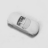

In [46]:
x = X_stereo[575]
x_img = vecs_to_img(x[0])
keras.utils.array_to_img(x_img, scale=False)

1/1 [==============================] - 2s 2s/step
-0.42304993
1.3551064
norm of x 0.9999999965932823
norm of y 0.8578118
93.090706
249.4308


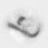

In [47]:
y = reconstruction_model.predict(tf.reshape(x, (1, 2, x_size * y_size, 1, 2)))
print(tf.reduce_min(y[0][0]).numpy())
print(tf.reduce_max(y[0][0]).numpy())
print('norm of x', tf.reduce_mean(tf.norm(x[0], axis=-1)).numpy())
print('norm of y', tf.reduce_mean(tf.norm(y[0][0], axis=-1)).numpy())
y_img = vecs_to_img(tf.squeeze(y[0][0]).numpy())
print(tf.reduce_min(y_img).numpy())
print(tf.reduce_max(y_img).numpy())
keras.utils.array_to_img(y_img, scale=False)

shape (2, 16, 24)
min -0.83421767
max 0.35137603
norm 1.7432371
max of diff 0.17086965
norm of diff 0.4683151


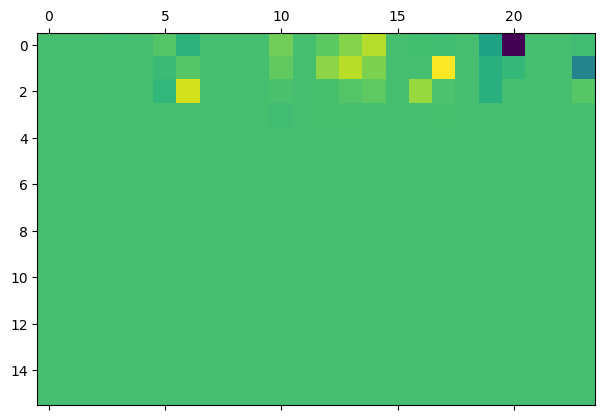

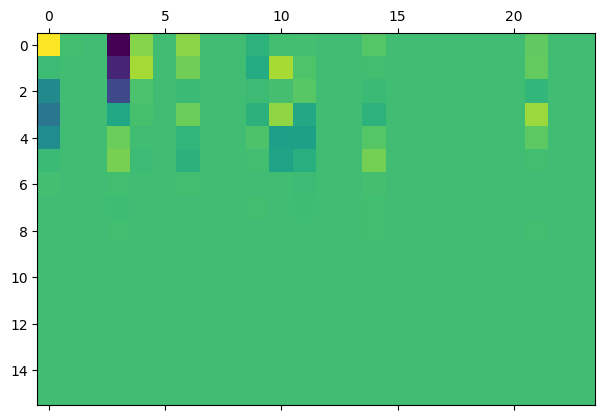

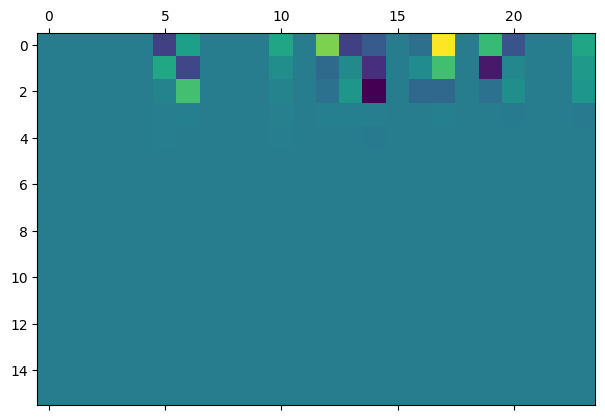

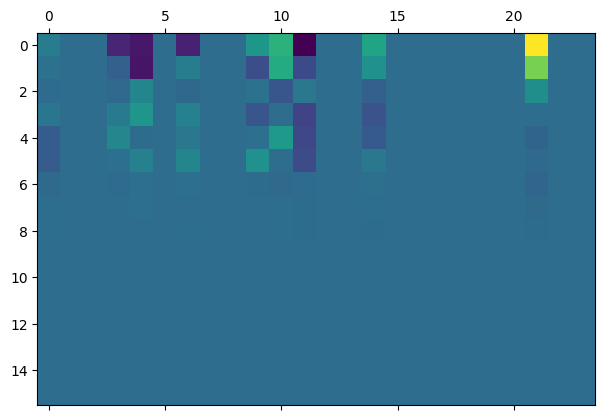

In [48]:
us = reconstruction_model.get_layer(index=1)(x.reshape((1, 2, x_size * y_size, 1, 2)), training=False)[0]
us = tf.cast(us, tf.float32)
one_us = us[0]
usd = one_us[0] - one_us[1]
one_us = one_us[0]
print('shape', one_us.shape)
print('min', tf.reduce_min(one_us).numpy())
print('max', tf.reduce_max(one_us).numpy())
print('norm', tf.norm(one_us).numpy())
print('max of diff', tf.reduce_max(tf.abs(usd)).numpy())
print('norm of diff', tf.norm(usd).numpy())
plt.matshow(one_us[0].numpy())
plt.matshow(one_us[1].numpy())
plt.matshow(usd[0].numpy())
plt.matshow(usd[1].numpy())

norm of diff 1.2722129
(1, 2, 2304, 1, 2)


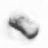

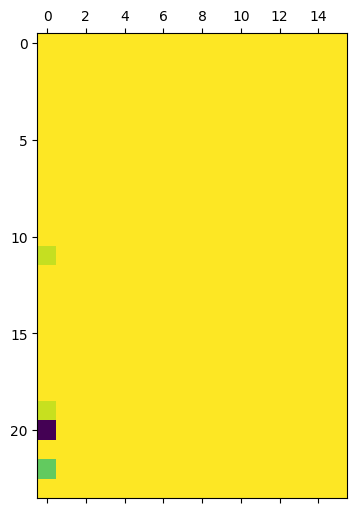

In [21]:
us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X_stereo[575], (1, 2, x_size * y_size, 1, 2)), training=False)[0]
us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X_stereo[291], (1, 2, x_size * y_size, 1, 2)), training=False)[0]
us1 = tf.cast(us1, tf.float32).numpy()
us2 = tf.cast(us2, tf.float32).numpy()
#us2[0][0] = us1[0][1]
print('norm of diff', tf.norm(us2-us1).numpy())
us_mod = us1
us_mod = (us1 + 0.5 * (us2 - us1))
#for i in range(1, 16):
#    us_mod[0][0][0][i] = np.zeros((40))
#us_mod[0][0][0][0] *= 16
#us_mod[0][0][0][1] = np.zeros((16))
#us_mod[0][0][0][15] = 0.2

#us_mod[0][0][1] = np.zeros((8, 16))
plt.matshow(us_mod[0][0][0].T)
r = l1.reconstruct(tf.cast(us_mod, tf.float32))
print(r.shape)
r_one = r[0][0]
r_img = vecs_to_img(tf.squeeze(r_one).numpy())
keras.utils.array_to_img(r_img, scale=False)

-0.46246752
0.33897564


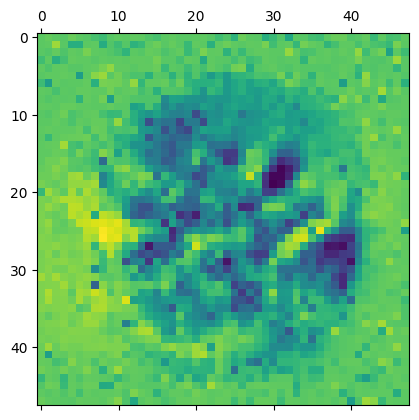

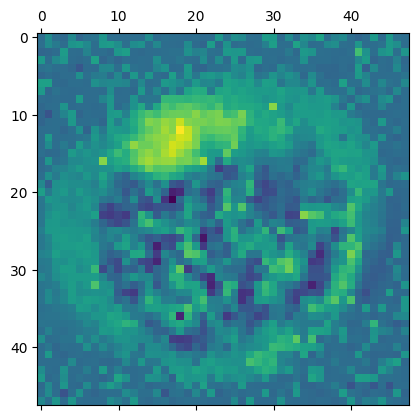

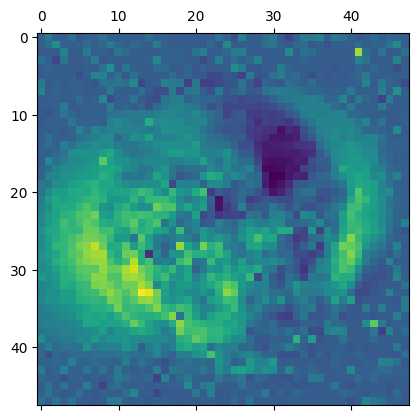

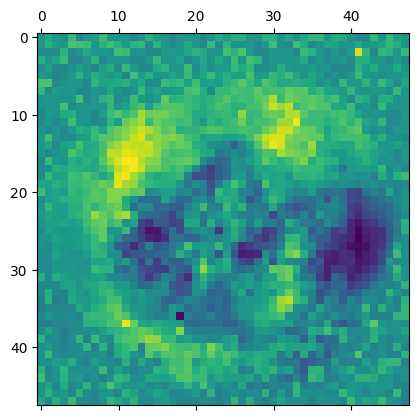

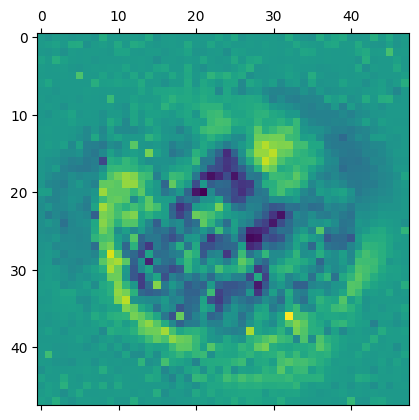

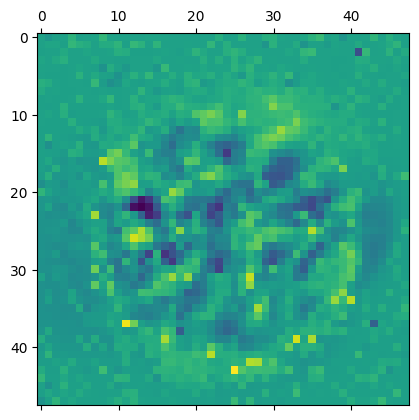

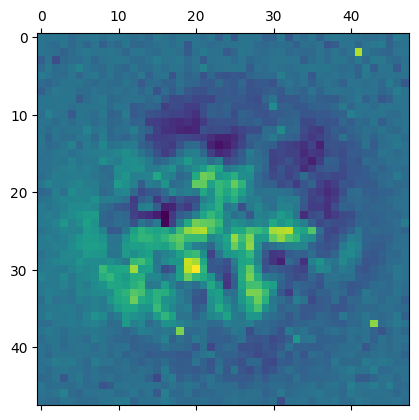

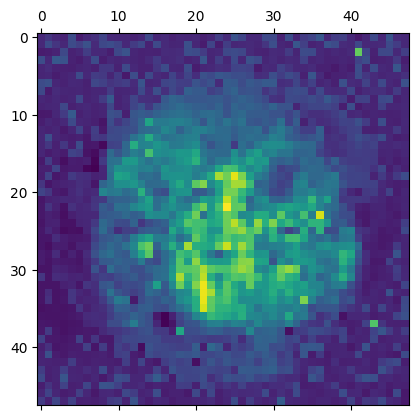

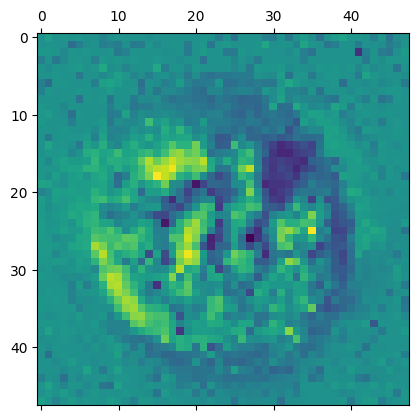

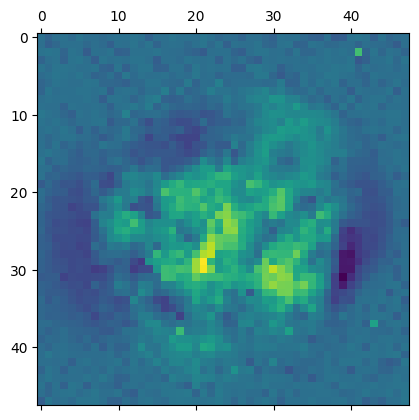

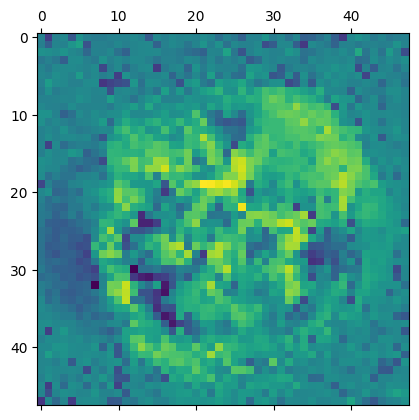

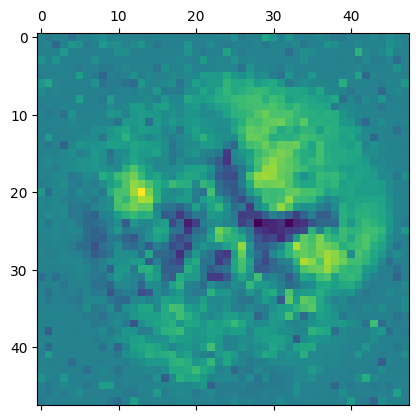

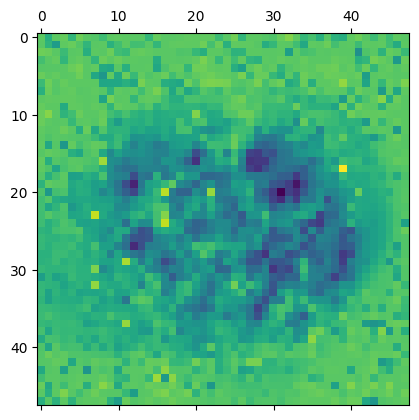

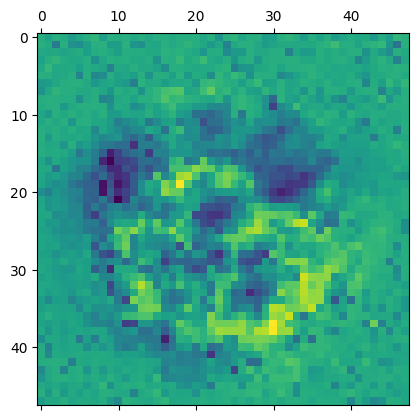

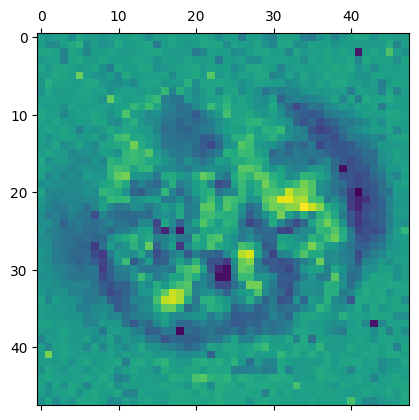

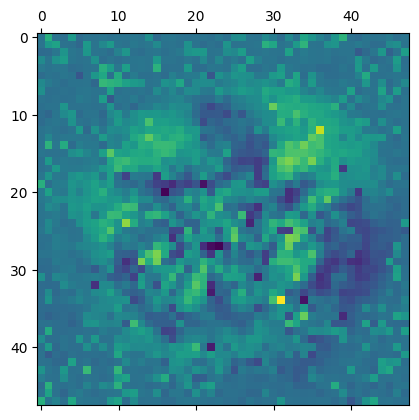

In [22]:
le = l1.columns[0].context_aggregator.downstream_type_positions.numpy()
le = le.reshape((x_size,y_size,-1))
print(tf.reduce_min(le[:, :, 0]).numpy())
print(tf.reduce_max(le[:, :, 0]).numpy())
for d in range(0, le.shape[2]):
    plt.matshow(le[:, :, d])

# Layer 2

In [ ]:
X_2 = upstream_state_model.predict(np.concatenate((X, X2)), batch_size=64)
#X_2 = upstream_state_model.predict(X, batch_size=64)

Y_2 = X_2

In [ ]:
inp_2 = Input(shape=(3, 1, 8, 40))
l2 = PtolemyLayer(
    num_types=1,
    num_instances_per_type=2,
    context_fan_in=8,
    upstream_dim=8,
    type_position_dim=0,
    instance_position_dim=8,
    stride=1,
    permanence_loss_rho=0.5,
    initial_sharpness=3.0,
    noise_rate=0.2,
    add_default=False,
)

upstream_state_2, downstream_reconstruction_2 = l2(inp_2)

reconstruction_model_2 = keras.models.Model(inputs=[inp_2], outputs=downstream_reconstruction_2)
upstream_state_model_2 = keras.models.Model(inputs=[inp_2], outputs=upstream_state_2)

optimizer_2 = keras.optimizers.Adam(
    learning_rate = 0.001,
    clipnorm=0.1,
)
#optimizer_2 = keras.mixed_precision.LossScaleOptimizer(optimizer_2)
reconstruction_model_2.compile(
    loss = zero_loss,
    optimizer = optimizer_2,
    metrics = ['cosine_similarity'],
)
reconstruction_model_2.summary()

In [ ]:
log_dir = "ptolemynet_logs/fit_layer2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=False)
animation_callbacks = [
    AnimateReconstruction(
        [l1, l2],
        tf.concat([X[i] for i in range(num_inputs_per_run)], axis=0),
        log_dir + "/animation_x1.gif",
    ),
    AnimateReconstruction(
        [l1, l2],
        tf.concat([X2[i] for i in range(num_inputs_per_run)], axis=0),
        log_dir + "/animation_x2.gif",
    )
]

tf.config.experimental.reset_memory_stats('GPU:0')
history = reconstruction_model_2.fit([X_2], Y_2, epochs=128, batch_size=64, callbacks=[tensorboard_callback] + animation_callbacks)
tf.config.experimental.get_memory_info('GPU:0')

In [ ]:
x_2 = X_2[4500]
#x_2 = X_2[570]
x_2_img = vecs_to_img(l1.reconstruct(tf.cast(tf.expand_dims(x_2, axis=0), tf.float32))[0][0].numpy())
keras.utils.array_to_img(x_2_img, scale=False)

In [ ]:
y_2 = reconstruction_model_2.predict(tf.reshape(x_2, (1, 3, 1, 8, 40)))[0]
y_2_img = vecs_to_img(l1.reconstruct(tf.cast(tf.expand_dims(y_2, axis=0), tf.float32))[0][0].numpy())
keras.utils.array_to_img(y_2_img, scale=False)

In [ ]:
plt.matshow(tf.cast(x_2[0], tf.float32).numpy().T)
plt.matshow(tf.cast(y_2[0], tf.float32).numpy().T)
print(tf.norm(x_2[0]).numpy())
print(tf.norm(y_2[0]).numpy())
rd = tf.cast(x_2[0], tf.float32).numpy() - tf.cast(y_2[0], tf.float32).numpy()
plt.matshow(np.abs(rd.T), vmin=0.0, vmax=0.5)

In [ ]:
us = reconstruction_model_2.get_layer(index=1)(x_2.reshape((1, 3, 1, 8, 40)), training=False)[0]
us = tf.cast(us, tf.float32)
one_us = us[0]
usd = one_us[0] - one_us[1]
print('shape', one_us[0].shape)
print('min', tf.reduce_min(one_us[0]).numpy())
print('max', tf.reduce_max(one_us[0]).numpy())
print('norm', tf.norm(one_us[0]).numpy())
print('max of diff', tf.reduce_max(tf.abs(usd)).numpy())
print('norm of diff', tf.norm(usd).numpy())
plt.matshow(one_us[0][0].numpy())
plt.matshow(one_us[1][0].numpy())
plt.matshow(usd[0].numpy())

In [ ]:
us_mod = us.numpy()
print(us_mod.shape)
us_mod[0][0][0][0] = np.zeros((8))
#us_mod[0][0][0][1] = np.zeros((8))

#us_mod[0][0][0][1][7] = -0.5

#us_mod[0][0] = us_mod[0][0] + 2.0 * (us_mod[0][1] - us_mod[0][0])
r = l2.reconstruct(us_mod)
r = l1.reconstruct(r)
y_2_mod_img = vecs_to_img(r[0][0].numpy())
keras.utils.array_to_img(y_2_mod_img, scale=False)

## Exports and animations

In [ ]:
def animate_interpolation(x1, x2, reconstruction_fun, filename, min_coeff=0.0, max_coeff=1.0, steps=20):
    fig = plt.figure()
    animate = lambda i: reconstruction_fun(x1 + (min_coeff + float(i) / steps * (max_coeff - min_coeff)) * (x2 - x1))
    anim = animation.FuncAnimation(fig, animate, frames=steps, interval=100, blit=True)
    anim.save(filename, fps=15, writer='imagemagick')
    plt.close(fig)

In [ ]:
def reconstruct_l1(x):
    recon = l1.reconstruct(x)[0][0]
    recon_im_array = vecs_to_img(tf.squeeze(recon).numpy())
    recon_im = keras.utils.array_to_img(recon_im_array, scale=False)
    return plt.imshow(recon_im, cmap='gray', vmin=0, vmax=255),

def reconstruct_l2(x):
    recon = l2.reconstruct(x)
    recon = l1.reconstruct(recon)[0][0]
    recon_im_array = vecs_to_img(tf.squeeze(recon).numpy())
    recon_im = keras.utils.array_to_img(recon_im_array, scale=False)
    return plt.imshow(recon_im, cmap='gray', vmin=0, vmax=255),

In [ ]:
us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X2[1], (1, 3, 2500, 1, 2)), training=False)[0]
us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X2[5], (1, 3, 2500, 1, 2)), training=False)[0]

animate_interpolation(us1, us2, reconstruct_l1, 'l1_test.gif', min_coeff=0.0, max_coeff=1.0, steps=40)

In [ ]:
us1 = reconstruction_model_2.get_layer(index=1)(tf.reshape(X_2[4001], (1, 3, 1, 8, 40)), training=False)[0]
us2 = reconstruction_model_2.get_layer(index=1)(tf.reshape(X_2[4005], (1, 3, 1, 8, 40)), training=False)[0]

animate_interpolation(us1, us2, reconstruct_l2, 'l2_test.gif', min_coeff=0.0, max_coeff=1.0, steps=40)

In [ ]:
for coordinate in range(8):
    us1_mod1 = us.numpy()
    us1_mod2 = us.numpy()
    us1_mod1[0][0][0][1] = np.zeros((8))
    us1_mod1[0][0][0][0][coordinate] = 0.0
    us1_mod2[0][0][0][1] = np.zeros((8))
    us1_mod2[0][0][0][0][coordinate] = 2.0

    animate_interpolation(us1_mod1, us1_mod2, reconstruct_l2, f'level_2_boxworld_coordinate_{coordinate}.gif', min_coeff=-1.0, max_coeff=1.0, steps=80)